For this tutorial, we follow Robyn Speer's 2017 blog post [How to make a racist AI without really trying](http://blog.conceptnet.io/posts/2017/how-to-make-a-racist-ai-without-really-trying/).

In [8]:
import numpy as np
import pandas as pd
import matplotlib
import seaborn
import re
import statsmodels.formula.api

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [9]:
# Configure how graphs will show up in this notebook
%matplotlib inline
seaborn.set_context('notebook', rc={'figure.figsize': (10, 6)}, font_scale=1.5)

### Load the embeddings

Download the embeddings from https://nlp.stanford.edu/data/glove.42B.300d.zip (we are using the 42B version here) and extract them into `data/glove.42B.300d.txt`.

In [10]:
def load_embeddings(filename):
    """
    Load a DataFrame from the generalized text format used by word2vec, GloVe,
    fastText, and ConceptNet Numberbatch. The main point where they differ is
    whether there is an initial line with the dimensions of the matrix.
    """
    labels = []
    rows = []
    with open(filename, encoding='utf-8') as infile:
        for i, line in enumerate(infile):
            items = line.rstrip().split(' ')
            if len(items) == 2:
                # This is a header row giving the shape of the matrix
                continue
            labels.append(items[0])
            values = np.array([float(x) for x in items[1:]], 'f')
            rows.append(values)
    
    arr = np.vstack(rows)
    return pd.DataFrame(arr, index=labels, dtype='f')

embeddings = load_embeddings('data/glove.42B.300d.txt')
embeddings.shape

(1917494, 300)

### Load the lexicon

Download the lexicon from Bing Liu’s web site (https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html#lexicon) and extract it into `data/positive-words.txt` and `data/negative-words.txt`.

In [11]:
def load_lexicon(filename):
    """
    Load a file from Bing Liu's sentiment lexicon
    (https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html), containing
    English words in Latin-1 encoding.
    
    One file contains a list of positive words, and the other contains
    a list of negative words. The files contain comment lines starting
    with ';' and blank lines, which should be skipped.
    """
    lexicon = []
    with open(filename, encoding='latin-1') as infile:
        for line in infile:
            line = line.rstrip()
            if line and not line.startswith(';'):
                lexicon.append(line)
    return lexicon

pos_words = load_lexicon('data/positive-words.txt')
neg_words = load_lexicon('data/negative-words.txt')

### Train a model to predict word sentiments

In [12]:
# Drop words that are not in the Glove vocabulary (e.g. misspellings such a "fancinating") 
pos_vectors = embeddings.reindex(pos_words).dropna()
neg_vectors = embeddings.reindex(neg_words).dropna()

# Make arrays for the desired inputs and outputs:
# the input are the embeddings, the outputs are -1 or 1
# depending on whether a word is positive or negative
vectors = pd.concat([pos_vectors, neg_vectors])
targets = np.array([1 for entry in pos_vectors.index] + [-1 for entry in neg_vectors.index])
labels = list(pos_vectors.index) + list(neg_vectors.index)

# Split into test and training data (we use 10% for testing)
train_vectors, test_vectors, train_targets, test_targets, train_labels, test_labels = \
    train_test_split(vectors, targets, labels, test_size=0.1, random_state=0)

# Make the classifier and train it. We run it for 100 iterations
model = SGDClassifier(loss='log', random_state=0, max_iter=100)
model.fit(train_vectors, train_targets)

# Evaluate the classifier on the test vectors
accuracy_score(model.predict(test_vectors), test_targets)

C:\Python\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


0.9441930618401206

### Word sentiment predictor functions

We use these functions to see some examples of the model's predictions on the test data.

In [13]:
def vecs_to_sentiment(vecs):
    # predict_log_proba gives the log probability for each class
    predictions = model.predict_log_proba(vecs)

    # To see an overall positive vs. negative classification in one number,
    # we take the log probability of positive sentiment minus the log
    # probability of negative sentiment.
    return predictions[:, 1] - predictions[:, 0]


def words_to_sentiment(words):
    vecs = embeddings.reindex(words).dropna()
    log_odds = vecs_to_sentiment(vecs)
    return pd.DataFrame({'sentiment': log_odds}, index=vecs.index)

In [14]:
# Show 20 examples from the test set
words_to_sentiment(test_labels).iloc[:20]

,sentiment
fidget,-10.523408
interrupt,-10.475247
staunchly,-0.187009
imaginary,-3.268410
taxing,-0.608206
world-famous,6.755397
low-cost,9.253170
disapointment,-9.399764
totalitarian,-13.588078
bellicose,-9.986888


### Get a sentiment score for text

To get the sentiment score for a text, we are going to average the sentiment scores of its tokens.

In [15]:
import re
TOKEN_RE = re.compile(r"\w.*?\b")
# The regex above finds tokens that start with a word-like character (\w), and continues
# matching characters (.+?) until the next word break (\b). It's a relatively simple
# expression that manages to extract something very much like words from text.


def text_to_sentiment(text):
    tokens = [token.casefold() for token in TOKEN_RE.findall(text)]
    sentiments = words_to_sentiment(tokens)
    return sentiments['sentiment'].mean()

Now let's test it on some sentences.

In [16]:
text_to_sentiment("this example is pretty cool")

3.5326145703559697

In [17]:
text_to_sentiment("this example is okay")

2.6261247874394917

In [18]:
text_to_sentiment("meh, this example sucks")

-1.4061096476615116

Now, let's try with a few more neutral sentences:

In [19]:
text_to_sentiment("Let's go get Italian food")

2.1737125117517766

In [20]:
text_to_sentiment("Let's go get Chinese food")

1.6942342359350466

In [21]:
text_to_sentiment("Let's go get Mexican food")

0.49386014970586317

More neutral sentences:

In [22]:
text_to_sentiment("My name is Emily")

2.0442191758937875

In [23]:
text_to_sentiment("My name is Heather")

1.364266357023753

In [24]:
text_to_sentiment("My name is Yvette")

0.8900111751765374

In [25]:
text_to_sentiment("My name is Shaniqua")

-0.7252843531798221

### Measuring the problem

We use `ConceptNet`'s lists of names typically associated with specific ethnic backgrounds. Some notes on the origins of each list are provided in the comments above the lists by Robyn Speer.

In [26]:
NAMES_BY_ETHNICITY = {
    # The first two lists are from the Caliskan et al. appendix describing the
    # Word Embedding Association Test.
    'White': [
        'Adam', 'Chip', 'Harry', 'Josh', 'Roger', 'Alan', 'Frank', 'Ian', 'Justin',
        'Ryan', 'Andrew', 'Fred', 'Jack', 'Matthew', 'Stephen', 'Brad', 'Greg', 'Jed',
        'Paul', 'Todd', 'Brandon', 'Hank', 'Jonathan', 'Peter', 'Wilbur', 'Amanda',
        'Courtney', 'Heather', 'Melanie', 'Sara', 'Amber', 'Crystal', 'Katie',
        'Meredith', 'Shannon', 'Betsy', 'Donna', 'Kristin', 'Nancy', 'Stephanie',
        'Bobbie-Sue', 'Ellen', 'Lauren', 'Peggy', 'Sue-Ellen', 'Colleen', 'Emily',
        'Megan', 'Rachel', 'Wendy'
    ],

    'Black': [
        'Alonzo', 'Jamel', 'Lerone', 'Percell', 'Theo', 'Alphonse', 'Jerome',
        'Leroy', 'Rasaan', 'Torrance', 'Darnell', 'Lamar', 'Lionel', 'Rashaun',
        'Tyree', 'Deion', 'Lamont', 'Malik', 'Terrence', 'Tyrone', 'Everol',
        'Lavon', 'Marcellus', 'Terryl', 'Wardell', 'Aiesha', 'Lashelle', 'Nichelle',
        'Shereen', 'Temeka', 'Ebony', 'Latisha', 'Shaniqua', 'Tameisha', 'Teretha',
        'Jasmine', 'Latonya', 'Shanise', 'Tanisha', 'Tia', 'Lakisha', 'Latoya',
        'Sharise', 'Tashika', 'Yolanda', 'Lashandra', 'Malika', 'Shavonn',
        'Tawanda', 'Yvette'
    ],
    
    # This list comes from statistics about common Hispanic-origin names in the US.
    'Hispanic': [
        'Juan', 'José', 'Miguel', 'Luís', 'Jorge', 'Santiago', 'Matías', 'Sebastián',
        'Mateo', 'Nicolás', 'Alejandro', 'Samuel', 'Diego', 'Daniel', 'Tomás',
        'Juana', 'Ana', 'Luisa', 'María', 'Elena', 'Sofía', 'Isabella', 'Valentina',
        'Camila', 'Valeria', 'Ximena', 'Luciana', 'Mariana', 'Victoria', 'Martina'
    ],
    
    # The following list conflates religion and ethnicity, I'm aware. So do given names.
    #
    # This list was cobbled together from searching baby-name sites for common Muslim names,
    # as spelled in English. I did not ultimately distinguish whether the origin of the name
    # is Arabic or Urdu or another language.
    #
    # I'd be happy to replace it with something more authoritative, given a source.
    'Arab/Muslim': [
        'Mohammed', 'Omar', 'Ahmed', 'Ali', 'Youssef', 'Abdullah', 'Yasin', 'Hamza',
        'Ayaan', 'Syed', 'Rishaan', 'Samar', 'Ahmad', 'Zikri', 'Rayyan', 'Mariam',
        'Jana', 'Malak', 'Salma', 'Nour', 'Lian', 'Fatima', 'Ayesha', 'Zahra', 'Sana',
        'Zara', 'Alya', 'Shaista', 'Zoya', 'Yasmin'
    ]
}

Now we use `pandas` to make a table of the names, their predominant ethnic background and the sentiment score we get for them.

In [27]:
def name_sentiment_table():
    frames = []
    for group, name_list in sorted(NAMES_BY_ETHNICITY.items()):
        lower_names = [name.lower() for name in name_list]
        sentiments = words_to_sentiment(lower_names)
        sentiments['group'] = group
        frames.append(sentiments)

    # Put together the data we got from each ethnic group into one big table
    return pd.concat(frames)

name_sentiments = name_sentiment_table()

In [28]:
name_sentiments.iloc[::25]

,sentiment,group
mohammed,0.891362,Arab/Muslim
alya,4.316360,Arab/Muslim
terryl,-2.916172,Black
josé,-0.320425,Hispanic
luciana,0.488444,Hispanic
hank,-0.052662,White
megan,1.936170,White


### Visualizations and stats

(-10.0, 10.0)

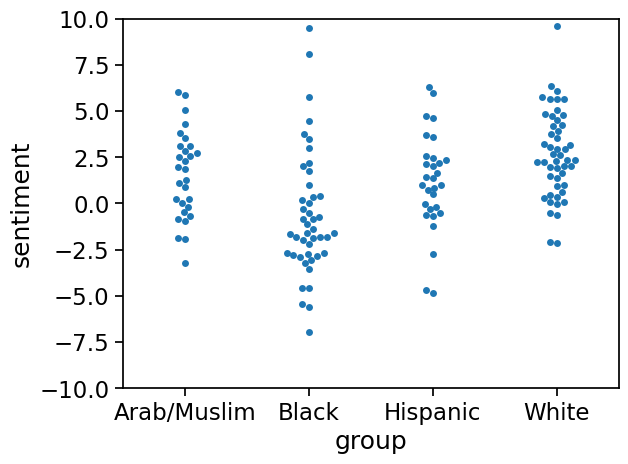

In [29]:
# we can visualize the distribution of sentiment we get for each kind of name
plot = seaborn.swarmplot(x='group', y='sentiment', data=name_sentiments)
plot.set_ylim([-10, 10])

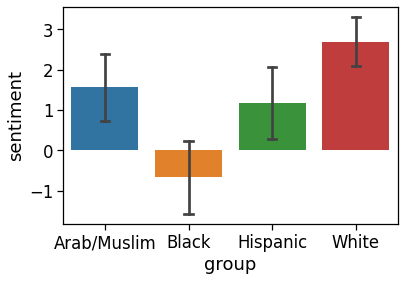

In [93]:
# we can also see that as a bar-plot, too, showing the 95% confidence intervals of the means
plot = seaborn.barplot(x='group', y='sentiment', data=name_sentiments, capsize=.1)

In [94]:
# we use the statsmodels package to see how big of an effect this is
ols_model = statsmodels.formula.api.ols('sentiment ~ group', data=name_sentiments).fit()
ols_model.summary().tables[0]

Dep. Variable:,sentiment,R-squared:,0.192
Model:,OLS,Adj. R-squared:,0.176
Method:,Least Squares,F-statistic:,11.81
Date:,"Thu, 23 Sep 2021",Prob (F-statistic):,5.52e-07
Time:,13:29:28,Log-Likelihood:,-369.41
No. Observations:,153,AIC:,746.8
Df Residuals:,149,BIC:,758.9
Df Model:,3,,
Covariance Type:,nonrobust,,


### Kings and queens and doctors and nurses

We'll use a "small" set of embeddings pretrained with Glove and the `spacy` library for this next exercise. You can install `spacy` with `pip install spacy` or `pip3 install spacy` and then download the embeddings with

```
python -m spacy download en_core_web_md
```
or

```
python3 -m spacy download en_core_web_md
```
depending on your system.

In [137]:
import spacy
spacy.info()
# Load the spacy model that you have downloaded
nlp = spacy.load('en_core_web_lg')
print("word embeddings loaded")

from numpy import dot
from numpy.linalg import norm

# Define coside similarity
cosine = lambda v1,v2: dot(v1,v2) / (norm(v1)*norm(v2))

# Get the words that have vectors
allwords = list({w for w in nlp.vocab if w.has_vector})

word embeddings loaded


In [138]:
def get_analogy(w1, w2, w3, n=10):
    ''' Analogy function. Returns the n closest possibilities.
    w1 is to w2 as w3 is to ... 
    e.g. "Italy is to Rome as France is to..." - result should be "Paris"
    params: w1, w2, w3 - the first, second and third word in the statement respectively
            n - how many words to return; default it 10
    '''
    w1_vector  = nlp(w1).vector
    w2_vector = nlp(w2).vector
    w3_vector   = nlp(w3).vector
    x = w2_vector - w1_vector + w3_vector
    allwords.sort(key=lambda w: cosine(w.vector,x))
    allwords.reverse()
    return [w.text for w in allwords[:10]]

In [139]:
get_analogy("man", "doctor", "woman")

['She', 'she', 'Dr.', 'Dr', 'who', 'Who', 'when', 'When', 'you', 'You']

In [140]:
get_analogy("italy", "rome", "france")

['Va', 'St', 'Ltd', 'Mont', 'La', 'co', 'Co', 'St.', 'Corp', 'Md']

In [141]:
get_analogy("man", "king", "woman")

['She', 'she', 'who', 'Who', 'r.', 'when', 'When', 'Dare', 'dare', 'Mrs']

In [142]:
get_analogy("king", "man", "queen")

['she', 'She', 'He', 'he', 'Who', 'who', 'When', 'when', 'could', 'Could']